- resnet, vggnet 모델 적용해보기
- signal data augmentation 적용해보기 (  signal segmentation and recombination in the time frequency design )

In [7]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
# gpu할당 확인
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError("GPU not found")
print('Found GPU at : {} '.format(device_name))

Found GPU at : /device:GPU:0 


In [9]:
# keras 버전 확인 
import keras
print(keras.__version__)

2.3.1


In [11]:
# 데이터 확인 

# train 데이터 
X_data = np.loadtxt('train_features.csv',skiprows=1,delimiter=',')
X_data = X_data[:,1:]
print(X_data.shape)
     
Y_data = np.loadtxt('train_target.csv',skiprows=1,delimiter=',')
Y_data = Y_data[:,1:]
print(Y_data.shape)

X_data = X_data.reshape((2800,375,5,1))
print(X_data.shape)

# test 데이터 
X_data_test = np.loadtxt('test_features.csv',skiprows=1,delimiter=',')
X_data_test = X_data_test[:,1:]
X_data_test = X_data_test.reshape((700,375,5,1))

(1050000, 5)
(2800, 4)
(2800, 375, 5, 1)


In [12]:
# 데이터 split
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)
print(X_train.shape)

(2240, 375, 5, 1)


In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten,MaxPooling2D,BatchNormalization,Lambda, AveragePooling2D
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import pandas as pd

In [14]:
# loss정의 
weight1 = np.array([1,1,0,0])
weight2 = np.array([0,0,1,1])

def my_loss(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult))


def my_loss_E1(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred)*weight1)/2e+04

def my_loss_E2(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult)*weight2)

In [15]:
# CNN 

def set_model(train_target):  # 0:x,y, 1:m, 2:v
    
    activation = 'elu'
    padding = 'valid'
    model = Sequential()
    nf = 16
    fs = (3,1)

    model.add(Conv2D(nf,fs, padding=padding, activation=activation,input_shape=(375,5,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*2,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*4,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*8,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*16,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*32,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Flatten())
    model.add(Dense(128, activation ='elu'))
    model.add(Dense(64, activation ='elu'))
    model.add(Dense(32, activation ='elu'))
    model.add(Dense(16, activation ='elu'))
    model.add(Dense(4))

    optimizer = keras.optimizers.Adam()

    global weight2
    if train_target == 1: # only for M
        weight2 = np.array([0,0,1,0])
    else: # only for V
        weight2 = np.array([0,0,0,1])
       
    if train_target==0:
        model.compile(loss=my_loss_E1,
                  optimizer=optimizer,
                 )
    else:
        model.compile(loss=my_loss_E2,
                  optimizer=optimizer,
                 )
       
    model.summary()

    return model

In [52]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import warnings

from . import get_submodules_from_kwargs
#from . import imagenet_utils
#from .imagenet_utils import decode_predictions
#from .imagenet_utils import _obtain_input_shape

#preprocess_input = imagenet_utils.preprocess_input

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.2/'
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.2/'
                       'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

backend = None
layers = None
models = None
keras_utils = None

In [53]:
# ResNet 

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """
    
    The identity block is the block that has no conv layer at shortcut.
    
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [54]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """
    conv_block is the block that has a conv layer at shortcut

    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)

    return x

In [58]:
def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)
    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

      
    x = ZeroPadding2D((3, 3))(input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    optimizer = keras.optimizers.Adam()

    global weight2
    if train_target == 1: # only for M
        weight2 = np.array([0,0,1,0])
    else: # only for V
        weight2 = np.array([0,0,0,1])
       
    if train_target==0:
        model.compile(loss=my_loss_E1,
                  optimizer=optimizer,
                 )
    else:
        model.compile(loss=my_loss_E2,
                  optimizer=optimizer,
                 )
       
    model.summary()
       

    return model

In [32]:
def train(model,X,Y):
    MODEL_SAVE_FOLDER_PATH = './model/'
    
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
    best_save = ModelCheckpoint('best_m.hdf5', save_best_only=True, monitor='val_loss', mode='min')


    history = model.fit(X, Y,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_split=0.2,
                  verbose = 2,
                  callbacks=[best_save])

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()    
    
    return model

In [33]:
def plot_error(type_id,pred,true):
    print(pred.shape)

    if type_id == 0:
        _name = 'x_pos'
    elif type_id == 1:
        _name = 'y_pos'
    elif type_id == 2:
        _name = 'mass'
    elif type_id == 3:
        _name = 'velocity'
    elif type_id == 4:
        _name = "distance"
    else:
        _name = 'error'

    x_coord = np.arange(1,pred.shape[0]+1,1)
    if type_id < 2:
        Err_m = (pred[:,type_id] - true[:,type_id])
    elif type_id < 4:
        Err_m = ((pred[:,type_id] - true[:,type_id])/true[:,type_id])*100
    else:
        Err_m = ((pred[:,0]-true[:,0])**2+(pred[:,1]-true[:,1])**2)**0.5


    fig = plt.figure(figsize=(8,6))
    # plt.rcParams["font.family"]="Times New Roman"
    plt.rcParams["font.size"]=15
    plt.scatter(x_coord, Err_m, marker='o')
    plt.title("%s Prediction for Training Data" % _name, size=20)
    plt.xlabel("Data ID", labelpad=10, size=20)
    plt.ylabel("Prediction Error of %s," % _name, labelpad=10, size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylim(-100., 100.)
    plt.xlim(0, pred.shape[0]+1)

    plt.show()
    
    print(np.std(Err_m))
    print(np.max(Err_m))
    print(np.min(Err_m))
    return Err_m


In [34]:
def load_best_model(train_target):

    if train_target == 0:
        model = load_model('best_m.hdf5' , custom_objects={'my_loss_E1': my_loss, })
    else:
        model = load_model('best_m.hdf5' , custom_objects={'my_loss_E2': my_loss, })

    score = model.evaluate(X_data, Y_data, verbose=0)
    print('loss:', score)

    pred = model.predict(X_data)

    i=0

    print('정답(original):', Y_data[i])
    print('예측값(original):', pred[i])
 
    
    if train_target ==0:
        plot_error(4,pred,Y_data)
    elif train_target ==1:
        plot_error(2,pred,Y_data)
    elif train_target ==2:
        plot_error(3,pred,Y_data)    
    
    return model

In [22]:
import os
import json
import numpy as np
from tqdm import tqdm

from keras.applications import ResNet50
from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 373, 5, 16)        64        
_________________________________________________________________
batch_normalization_1 (Batch (None, 373, 5, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 186, 5, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 184, 5, 32)        1568      
_________________________________________________________________
batch_normalization_2 (Batch (None, 184, 5, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 92, 5, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 5, 64)        

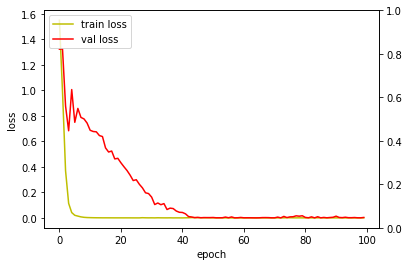

loss: 449905887711.81714
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [   1.1561835 -398.18234     19.317606  -224.44466  ]
(2800, 4)


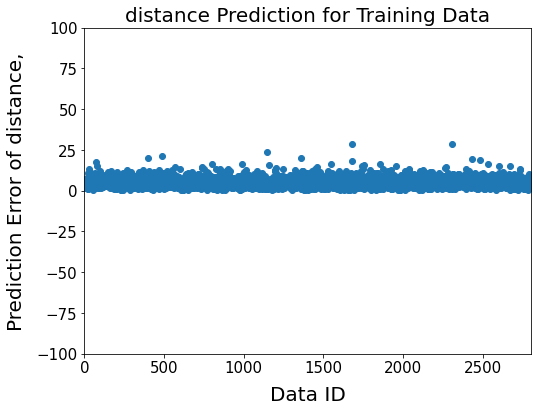

2.874526120182199
28.950020436894185
0.1460623447301494
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 373, 5, 16)        64        
_________________________________________________________________
batch_normalization_7 (Batch (None, 373, 5, 16)        64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 186, 5, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 184, 5, 32)        1568      
_________________________________________________________________
batch_normalization_8 (Batch (None, 184, 5, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 92, 5, 32)         0         
________________________________________________________________

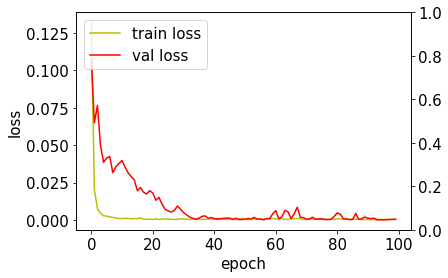

loss: 697374871889978.5
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [-48.917103 -37.891857  49.5787    13.433788]
(2800, 4)


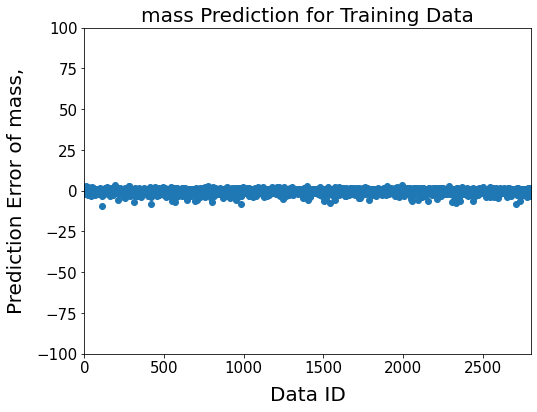

1.315330495200988
3.7973480224609375
-9.190473284040177
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 373, 5, 16)        64        
_________________________________________________________________
batch_normalization_13 (Batc (None, 373, 5, 16)        64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 186, 5, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 184, 5, 32)        1568      
_________________________________________________________________
batch_normalization_14 (Batc (None, 184, 5, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 92, 5, 32)         0         
________________________________________________________________

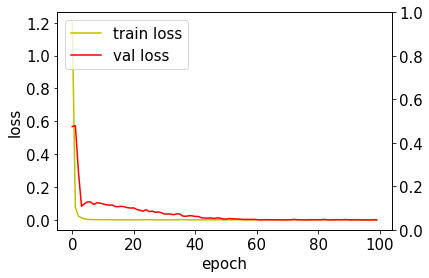

loss: 569093725318.5829
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [-0.17918341  2.5135396  -3.142322    0.3499357 ]
(2800, 4)


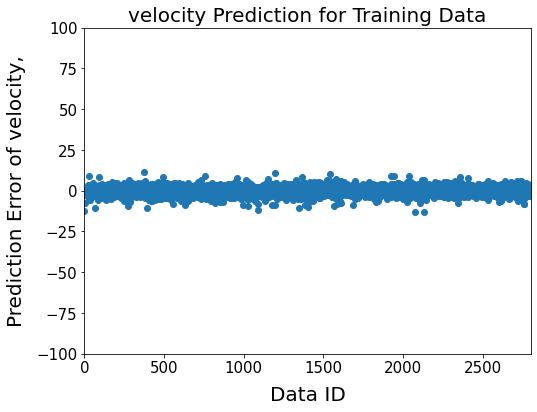

2.56896176781082
11.535176634788508
-13.282759487628942


In [23]:
# CNN 학습 
# 각 X,Y,V,M 학습하여 제출데이터에 저장 

submit = pd.read_csv('sample_submission.csv')

for train_target in range(3):
    model = set_model(train_target)
    train(model,X_train, Y_train)    
    best_model = load_best_model(train_target)

   
    pred_data_test = best_model.predict(X_data_test)
    
    
    if train_target == 0: # x,y 학습
        submit.iloc[:,1] = pred_data_test[:,0]
        submit.iloc[:,2] = pred_data_test[:,1]

    elif train_target == 1: # m 학습
        submit.iloc[:,3] = pred_data_test[:,2]

    elif train_target == 2: # v 학습
        submit.iloc[:,4] = pred_data_test[:,3]

In [60]:
'''
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
'''

In [69]:
# resnet 학습 
# 모델 객체 생성
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform
submit = pd.read_csv('sample_submission.csv')

for train_target in range(3):
    model = ResNet50(include_top=True,weights=None,input_shape= (224, 224, 1))
       
    model.summary()

    # load weights
    optimizer = keras.optimizers.Adam()

    global weight2
    if train_target == 1: # only for M
        weight2 = np.array([0,0,1,0])
    else: # only for V
        weight2 = np.array([0,0,0,1])
       
    if train_target==0:
        model.compile(loss=my_loss_E1)
    else:
        model.compile(loss=my_loss_E2 )
       
    train(model,X_train, Y_train)    
    best_model = load_best_model(train_target, input_shape =  (224, 224, 1))

   
    pred_data_test = best_model.predict(X_data_test)
    
    
    if train_target == 0: # x,y 학습
        submit.iloc[:,1] = pred_data_test[:,0]
        submit.iloc[:,2] = pred_data_test[:,1]

    elif train_target == 1: # m 학습
        submit.iloc[:,3] = pred_data_test[:,2]

    elif train_target == 2: # v 학습
        submit.iloc[:,4] = pred_data_test[:,3]

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 1)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

AttributeError: ignored

In [ ]:
submit.to_csv('submit3.csv', index = False)